**Selenium EXERCISE 1:** <BR>
<ul>
<li> Open a browser 

<li>Go to tripadvisor/Restaurants

<li>Find the search text box

<li>Clear it, input the query "Sant Cugat" and send it

<li>Go to "Restarurants" and get all the links and names of top 10 restaurants in Sant cugat
<li> Store them in a list of Dictionaries {name,links}
</ul>


In [1]:
import pymongo
import certifi
from datetime import datetime
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import time,os
import pandas as pd
import requests
import json
from tqdm import tqdm
import re
import os

In [2]:
try:
    #create a credentials.txt file in this folder:
    #first line: Database username (not account username)
    #second line: Database username password (not account password)
    #third line: Databse url with port (you can find it in the cloud dashboard)
    #fourth lin: Database name
    if 'conn' in globals():
        conn.close()
        print("Closing")
    
    with open("credentials.txt", 'r') as f:
        [name,password,url,dbname]=f.read().splitlines()
    conn=pymongo.MongoClient("mongodb+srv://{}:{}@{}".format(name,password,url),tlsCAFile=certifi.where())
    
    print ("Connected successfully!!!")
    
except pymongo.errors.ConnectionFailure as e:
    print ("Could not connect to MongoDB: %s" % e) 
conn
db = conn[dbname]
db

Connected successfully!!!


Database(MongoClient(host=['dataagile-shard-00-00.p4jpe.mongodb.net:27017', 'dataagile-shard-00-01.p4jpe.mongodb.net:27017', 'dataagile-shard-00-02.p4jpe.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-ksq9m0-shard-0', ssl=True, ssl_ca_certs='/home/johnny/anaconda3/lib/python3.8/site-packages/certifi/cacert.pem'), 'DataAgile')

In [5]:
url = 'https://www.tripadvisor.es/Restaurants' #Poseu el nom de la pàgina web
browser = webdriver.Chrome("./chromedriver") #Obrir un navegador Chrome
browser.get(url)
time.sleep(3)
nav_bar = browser.find_element_by_css_selector("input[placeholder='Ciudad o nombre del restaurante']")
time.sleep(3)
nav_bar.clear()
nav_bar.send_keys("Sant Cugat")
time.sleep(3)
nav_bar.send_keys(Keys.DOWN)
time.sleep(3)
nav_bar.send_keys(Keys.ENTER)
time.sleep(3)

db = conn['DataAgile']
db.drop_collection("Restaurants")
collection = db.Restaurants

for i in tqdm(range(1,11)):
    restaurant = browser.find_element_by_xpath('//div[@data-test="%s_list_item"]' % i)
    restaurant_name = restaurant.text.split("\n")[0]
    restaurant_link = restaurant.find_element_by_tag_name("a")
    collection.insert_one({'name':restaurant_name,'link': restaurant_link.get_attribute("href")})

conn.close()

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.56it/s]


In [6]:
restaurants = pd.DataFrame.from_dict(collection.find({},{"_id":0}))
restaurants

,name,link
0,1. Piaceri D’ Italia Ristorante Pizzeria,https://www.tripadvisor.es/Restaurant_Review-g...
1,2. Restaurant Brau,https://www.tripadvisor.es/Restaurant_Review-g...
2,3. Sabàtic,https://www.tripadvisor.es/Restaurant_Review-g...
3,4. Némesis Gastronomia,https://www.tripadvisor.es/Restaurant_Review-g...
4,5. Dakidaya,https://www.tripadvisor.es/Restaurant_Review-g...
5,6. 9Reinas Sant Cugat,https://www.tripadvisor.es/Restaurant_Review-g...
6,7. Kitsune Sushi Bar,https://www.tripadvisor.es/Restaurant_Review-g...
7,8. La Rampa 23,https://www.tripadvisor.es/Restaurant_Review-g...
8,9. La Rita,https://www.tripadvisor.es/Restaurant_Review-g...
9,10. El vi de deu,https://www.tripadvisor.es/Restaurant_Review-g...


**Selenium EXERCISE 2:**

* Go to Eix Macià Cinemes web Site. ('http://www.cinemeseixmacia.com/')
* Find all the movies that are currently playing in the Cinema.
* Filter those movies that starts from at specific time (i.e. 18PM) to 1h and half later and are recomended for a specific age audience (i.e 18 y.o).
* Search in themoviedb the average ratings for those movies and select the best one. 
* Play the movie trailer.

In [20]:
url = 'http://www.cinemeseixmacia.com/' #Poseu el nom de la pàgina web
browser = webdriver.Chrome("./chromedriver") #Obrir un navegador Chrome
browser.get(url)
time.sleep(3)
all_films = browser.find_elements(By.CLASS_NAME, "overlay")
result = []
for film in tqdm(all_films):
    name = film.find_element_by_tag_name("a").get_attribute("name")
    link = film.find_element_by_tag_name("a").get_attribute("href")
    trailer = film.find_element_by_class_name("peli-botons").find_element_by_tag_name("a").get_attribute("href")
    age = film.find_element_by_id('dadespeli').find_element_by_class_name('classi').get_attribute('textContent')
    hours = film.find_elements_by_class_name('horasessio')
    film_hours = []
    for hour in hours:
        result.append({'name': name, 
                        'link': link,
                        'trailer': trailer,
                        'age': int(age.split(' ')[0]) if age.split(' ')[0] != 'APTA' else 18, 
                        'schedule': datetime.strptime(hour.get_attribute('textContent').strip(), "%H:%M").time()})

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.73it/s]


In [21]:
movies = pd.DataFrame.from_dict(result)
movies = movies[movies['age'] <= 18]
movies = movies[(movies['schedule'] >= datetime.strptime("18:00", "%H:%M").time()) & (movies['schedule'] <= datetime.strptime("19:30", "%H:%M").time())]

In [22]:
movies

,name,link,trailer,age,schedule
0,ATMOS SIN TIEMPO PARA MORIR,https://www.cinemeseixmacia.com//film-2636/p?a...,https://www.cinemeseixmacia.com/ww.youtube.com...,12,18:15:00
3,DUNE,https://www.cinemeseixmacia.com//film-2846/p?dune,https://www.youtube.com/watch?v=URZHn_Dj7VU,12,19:00:00
6,LA FAMILIA ADDAMS 2 - LA GRAN ESCAPADA,https://www.cinemeseixmacia.com//film-2858/p?l...,https://www.youtube.com/watch?v=rfETRi0EP_I,18,18:15:00
10,LA PATRULLA CANINA:LA PELICULA,https://www.cinemeseixmacia.com//film-2829/p?l...,https://www.youtube.com/watch?v=6e24FI4hmm0,18,18:00:00
12,LAS LEYES DE LA FRONTERA,https://www.cinemeseixmacia.com//film-2857/p?l...,https://www.youtube.com/watch?v=9Oyn0cqenaE,16,19:00:00
15,MADRES PARALELAS,https://www.cinemeseixmacia.com//film-2859/p?m...,https://www.youtube.com/watch?v=2IO_f2Auo3U,12,19:00:00
22,NO RESPIRES 2,https://www.cinemeseixmacia.com//film-2853/p?n...,https://www.youtube.com/watch?v=en_3ZnETSGE,16,18:00:00
26,VOSE ¿QUIÉN ES QUIÉN?,https://www.cinemeseixmacia.com//film-2860/p?v...,https://www.youtube.com/watch?v=-vGwbSSTJ_g,7,18:00:00


In [24]:
with open('api_key', 'r') as f:
    API_KEY = f.read()

parameters = {"api_key": API_KEY}
result = []

for i in tqdm(movies['name'].values.tolist()):
    i_split = re.sub( r'[^\w]', ' ', i)
    url = "https://api.themoviedb.org/3/search/movie?query={}".format(i)
    res = requests.get(url, params = parameters).json()['results']
    result.append({'title': i, 'vote_average': res[0]['vote_average'] if res else 0})
            
result = sorted(result, key = lambda x: x['vote_average'], reverse = True)
url = movies[movies.name == result[0]['title']]['trailer'].values[0]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]


In [25]:
display(result)
print(result[0], url)

[{'title': 'DUNE', 'vote_average': 8.1},
 {'title': 'NO RESPIRES 2', 'vote_average': 7.8},
 {'title': 'LA FAMILIA ADDAMS 2 - LA GRAN ESCAPADA', 'vote_average': 7.6},
 {'title': 'LAS LEYES DE LA FRONTERA', 'vote_average': 7},
 {'title': 'MADRES PARALELAS', 'vote_average': 6.6},
 {'title': 'ATMOS SIN TIEMPO PARA MORIR', 'vote_average': 0},
 {'title': 'LA PATRULLA CANINA:LA PELICULA', 'vote_average': 0},
 {'title': 'VOSE ¿QUIÉN ES QUIÉN?', 'vote_average': 0}]

{'title': 'DUNE', 'vote_average': 8.1} https://www.youtube.com/watch?v=URZHn_Dj7VU


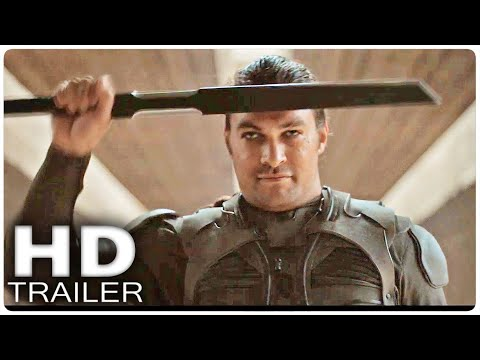

In [26]:
from IPython.display import YouTubeVideo
YouTubeVideo(url[url.index('=')+ 1:])

In [27]:
browser.get(url)